In [1]:
import pyxdf
import numpy as np
import pandas as pd

In [2]:
DATA_PATH = "data/muse_sample.xdf"

In [17]:
def load_experiment_data(xdf_path):
    print(f"Loading {xdf_path}")
    streams, header = pyxdf.load_xdf(xdf_path, synchronize_clocks=True)
    dataset = {
        "beam": None,
        "polar_ecg": None,
        "muse_eeg": None,
        "muse_optics": None,
        "muse_accgyro": None,
        "omnibuds_ppg": None,
        "omnibuds_acc": None,
        "omnibuds_gyro": None,
        "omnibuds_mag": None,
        "band_gsr": None,
        "band_hr": None,
        "user_ratings": None,
        "video_timestamp": None
    }
    
    for stream in streams:
        stream_name = stream['info']['name'][0]
        stream_type = stream['info']['type'][0]
        
        data = stream['time_series']
        timestamps = stream['time_stamps']

        if "Muse" in stream_name:
            if "EEG" in stream_name or "EEG" in stream_type:
                dataset["muse_eeg"] = (timestamps, data)
                print(f"Found Muse EEG ({len(data)} samples)")
            elif "OPTICS" in stream_name or "PPG" in stream_type:
                dataset["muse_optics"] = (timestamps, data)
                print(f"Found Muse Optics ({len(data)} samples)")
            elif "ACCGYRO" in stream_name or "ACCGYRO" in stream_type:
                dataset["muse_accgyro"] = (timestamps, data)
                print(f"Found Muse IMU ({len(data)} samples)")
    
    return dataset


import matplotlib.pyplot as plt
import numpy as np

def quick_plot_muse(dataset, stream_type="EEG", duration=10):
    """
    Plots Muse data streams directly from the dataset dictionary.
    
    Args:
        dataset: The dictionary returned by load_experiment_data.
        stream_type: "EEG", "OPTICS", or "GYRO" (case insensitive).
        duration: How many seconds to plot (from the start).
    """
    # 1. Map the friendly name to the dictionary key
    key_map = {
        "EEG": "muse_eeg",
        "OPTICS": "muse_optics",
        "PPG": "muse_optics",    # Alias
        "FNIRS": "muse_optics",  # Alias
        "ACCGYRO": "muse_accgyro"
    }
    
    target_key = key_map.get(stream_type.upper())
    
    if not target_key:
        print(f"❌ Unknown stream type: '{stream_type}'. Use EEG, OPTICS, or GYRO.")
        return

    # 2. Extract Data safely
    stream_tuple = dataset.get(target_key)
    if stream_tuple is None:
        print(f"⚠️ No data found for {stream_type} (Key: {target_key} is empty).")
        return

    timestamps, data = stream_tuple

    # 3. Zero the time axis
    t = timestamps - timestamps[0]
    
    # 4. Slice only the first 'duration' seconds
    mask = t < duration
    t_plot = t[mask]
    d_plot = data[mask]
    
    # 5. Plotting Logic
    plt.figure(figsize=(12, 4))
    
    if stream_type.upper() == "EEG":
        # Center the signals (remove DC offset)
        ch_names = ["TP9", "AF7", "AF8", "TP10", "Aux"]
        for i in range(min(d_plot.shape[1], 4)):
            centered_sig = d_plot[:, i] - np.mean(d_plot[:, i])
            plt.plot(t_plot, centered_sig, label=ch_names[i], lw=1, alpha=0.8)
        plt.ylabel("Amplitude (uV - Centered)")
        plt.title(f"Muse EEG (First {duration}s)")

    elif stream_type.upper() in ["OPTICS", "PPG", "FNIRS"]:
        # Do NOT center optics; we need the raw intensity to see the DC drift
        labels = ["Ambient", "Infrared (HbO)", "Red (HbR)"]
        colors = ["grey", "purple", "red"]
        for i in range(min(d_plot.shape[1], 3)):
            # If 3 channels found, use specific colors. If fewer, default logic.
            lbl = labels[i] if i < 3 else f"Ch {i}"
            clr = colors[i] if i < 3 else None
            plt.plot(t_plot, d_plot[:, i], label=lbl, color=clr, lw=1.5)
        plt.ylabel("Raw Light Intensity")
        plt.title(f"Muse Optics/fNIRS (First {duration}s)")

    elif stream_type.upper() == "ACCGYRO":
        labels = ["X", "Y", "Z"]
        for i in range(min(d_plot.shape[1], 3)):
            plt.plot(t_plot, d_plot[:, i], label=f"Gyro {labels[i]}")
        plt.ylabel("Rotation (deg/s)")
        plt.title(f"Muse Gyroscope (First {duration}s)")

    plt.xlabel("Time (s)")
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



Loading data/muse_sample.xdf
Found Muse IMU (1479 samples)
Found Muse EEG (7584 samples)
Found Muse Optics (1887 samples)


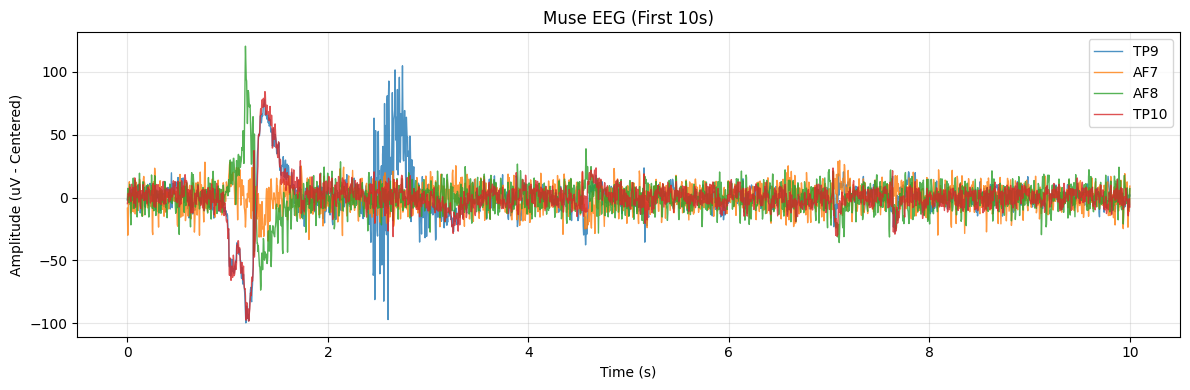

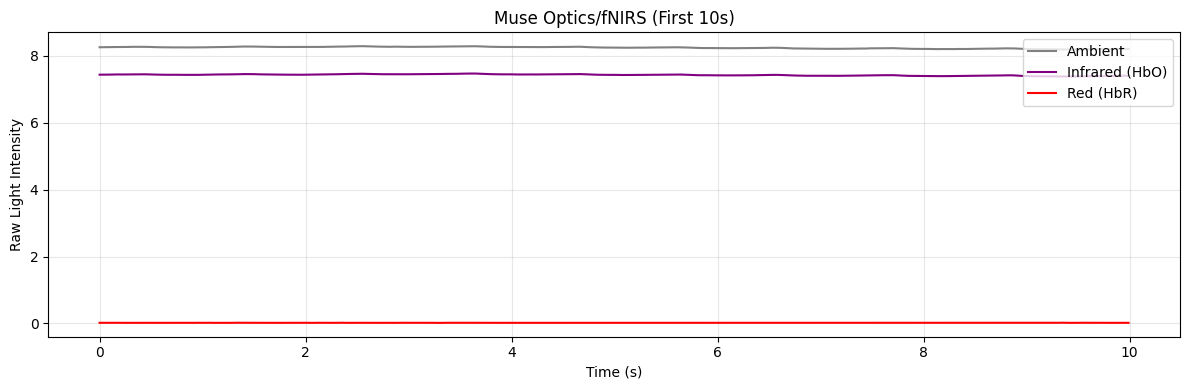

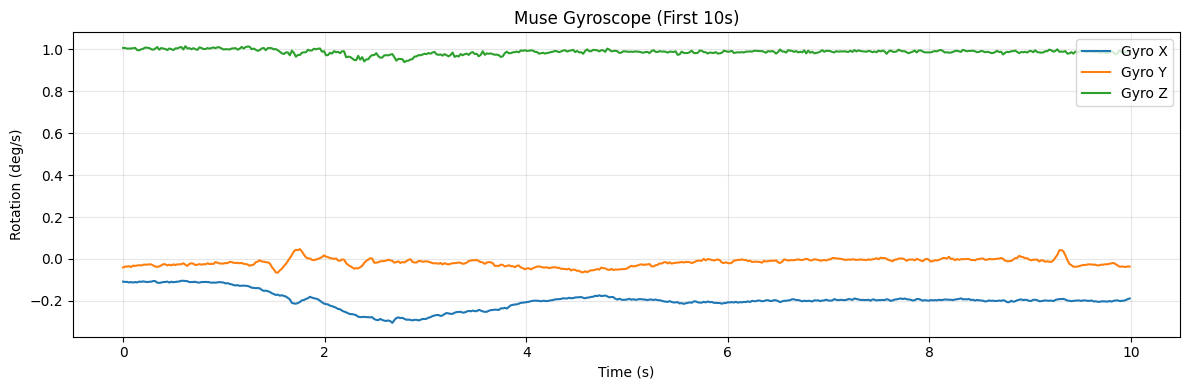

In [18]:
data_dict = load_experiment_data(DATA_PATH)
# ==========================================
# USAGE
# ==========================================

# Assuming 'data_dict' is the variable from your ingestion step:
quick_plot_muse(data_dict, "EEG")     # Checks brainwaves
quick_plot_muse(data_dict, "OPTICS")  # Checks fNIRS raw values
quick_plot_muse(data_dict, "ACCGYRO")    # Checks head movement